# Assignment 3: DLT, Two-View Geometry and PnP

Roll number: 2019101068

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment. 
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- Make sure any extra files you that you need to submit, place it in *'results'* folder.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- We recommend early start of this assignment. As this assignment is quite heavy.
- **Download the data folder from this [link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/ayush_sharma_students_iiit_ac_in/ErFTcJxQfO1KhaCo3m_9erwBj8M6-eeN8AO8e1bl4MXcBg?e=pdJR7F)**
- The **deadline** for this assignment is on **4/11/2022 at 11:55pm**.
- Plagiarism is **strictly prohibited**.



In [1]:
#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

**Objective of the assignment:** 

So, far you have learnt a subset of basics of Mobile-Robotics concept existing out there in the real world. This includes transformation theory, ICP, Data representations, Non-linear least square optimisation and more importantly SLAM pipelines(explored SLAM backend in Assignment2). In this assignment, you'll be dealing with vision part of the course. Starting with some hands on camera caliberation technique and two-view geometry concepts like epipolar geometry to estimate fundamental matrix, triangulation and later PnP exercise. There are bonus questions that will definitely help to fetch extra marks and cover up at places where you may lost marks in previous assignments. So, do target to attempt them. 

### Due to common code across the 3 questions in the assignment, I have implemented some common functions in `helper_utils/dlt_related.py`


# 1. Camera Calibration [DLT and Variants]

Briefly explain **DLT and it's shortcomings**. Refer to the provide rubik's image and follow the below points for deliverables:

1. Generate 2D-3D correspondences. Check provided code for selecting points on an image in below cells. Take a corresponding world co-ordinate for each chosen image points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units. Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

2. Implement a function that accepts these correspondences and return estimated P matrix.
    Quick recap: $$x_i = P * X_i  where (x_i, X_i)$$ is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].

3. Visualize the world points on the image using P matrix and report reprojection error of your P matrix for the same correspondences. You need to implement three different functions named `get_reprojected_points(P, X_world)`, `visualise(P, X_world, img_path)` and `get_reprojection_err(P, X_world, X_image)`.

4. Write the function that returns K, R, t given P as an argument. Next use `np.isclose()` to verify the R,K,T values.

5. Read upon Ransac based DLT and Zhangs method for camera caliberation and write the steps involved in each.

![Cube](./data/1/dlt1.jpeg)

## ---------------------------------------------------------

### TODO 1: DLT and it's shortcomings
Briefly explain **DLT and it's shortcomings**. Refer to the provide rubik's image and follow the below points for deliverables:

##### Answer
DLT needs a minimum of 6 points but an exact SVD-based solution is NOT always
possible. (reason below)

**Why might an exact solution not be possible ?**
Since the mapping might be measured inexactly (“noise”), if more than some 6 such
correspondences are given, then these correspondences may not be fully compatible with
any projective transformation, and one will be faced with the task of determining the “best”
transformation given the data.
There are two main categories of cost function:
1. Those based on minimizing an algebraic error; and
2. Those based on minimizing a geometric or statistical image distance.

###### Some shortcomings:

* DLT does not work when all the points lie on the same plane. This is because, in this case, the "P" matrix becomes degenerate ie using a addition/subtraction linear combination of rows, we can make one of the other rows zero.

* Also, DLT does not work when all points and the projection centre are located on a twisted cubic curve
* Since DLT is based on a least squares approach, even a single outlier can lead to huge inaccuracy in results.

#### My derivation and proof for DLT can be found in: pages 0 to 10 of `docs/DLT and Zhang's Proof.pdf`

# Generating correspondences
1. Generate 2D-3D correspondences. Check provided code for selecting points on an image in below cells. Take a corresponding world co-ordinate for each chosen image points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units. Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [2]:
import cv2
import json
import importlib
import matplotlib.pyplot as plt

In [3]:
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)

<module 'helper_utils.annotate_images' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/annotate_images.py'>

In [4]:
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)

<module 'helper_utils.dlt_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/dlt_related.py'>

##### Using the following tool to get the pixel coordinates
https://pixspy.com/ 

In [5]:
with open("cube_img_pixels.json", 'r') as fd:
    pixels_df=json.load(fd)
    pixels_df = [x.split(",") for x in pixels_df]
    pixels_df = [[int(y) for y in x] for x in pixels_df]

In [6]:
curr_frame = cv2.imread("./data/1/dlt1.jpeg")
print("Size of image is ", curr_frame.shape)

Size of image is  (1152, 648, 3)


In [7]:
print("Number of points in the image is: ", len(pixels_df))

Number of points in the image is:  18


Text(0.5, 1.0, 'Original image')

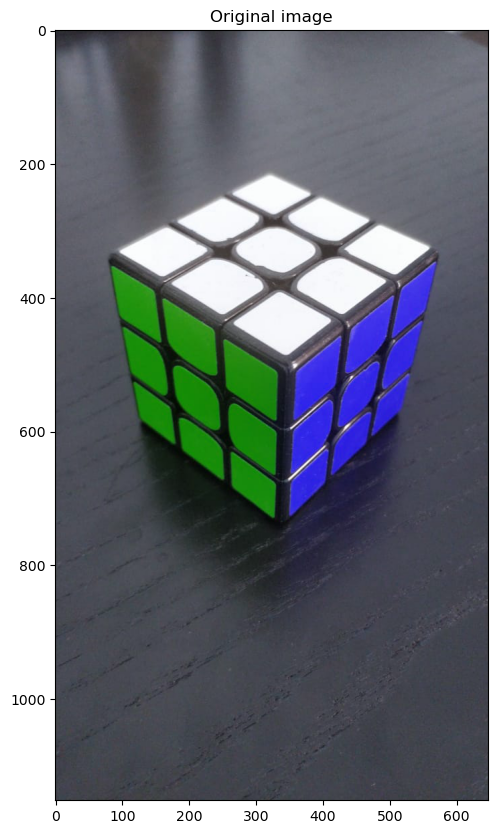

In [8]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(curr_frame)
plt.title("Original image")

#### Prepare arguments for DLT

In [9]:
X_img=[]
for curr_elem in pixels_df:
    X_img.append([curr_elem[0], curr_elem[1], 1])

In [10]:
X_img=np.vstack(X_img).transpose().astype(float)

In [11]:
X_img.shape

(3, 18)

In [12]:
X_img

array([[339., 411., 472., 516., 258., 184., 126., 344., 345., 345., 334.,
         80., 563., 316., 477., 173., 246., 429.],
       [736., 675., 611., 566., 686., 629., 589., 674., 600., 506., 382.,
        342., 334., 214., 283., 289., 449., 438.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.]])

In [13]:
# Printing all the pixel coordinates just to be sure:
for i in range(X_img.shape[1]):
    print(f"Pixel coordinates for Point {i} is : ",X_img[:, i])

Pixel coordinates for Point 0 is :  [339. 736.   1.]
Pixel coordinates for Point 1 is :  [411. 675.   1.]
Pixel coordinates for Point 2 is :  [472. 611.   1.]
Pixel coordinates for Point 3 is :  [516. 566.   1.]
Pixel coordinates for Point 4 is :  [258. 686.   1.]
Pixel coordinates for Point 5 is :  [184. 629.   1.]
Pixel coordinates for Point 6 is :  [126. 589.   1.]
Pixel coordinates for Point 7 is :  [344. 674.   1.]
Pixel coordinates for Point 8 is :  [345. 600.   1.]
Pixel coordinates for Point 9 is :  [345. 506.   1.]
Pixel coordinates for Point 10 is :  [334. 382.   1.]
Pixel coordinates for Point 11 is :  [ 80. 342.   1.]
Pixel coordinates for Point 12 is :  [563. 334.   1.]
Pixel coordinates for Point 13 is :  [316. 214.   1.]
Pixel coordinates for Point 14 is :  [477. 283.   1.]
Pixel coordinates for Point 15 is :  [173. 289.   1.]
Pixel coordinates for Point 16 is :  [246. 449.   1.]
Pixel coordinates for Point 17 is :  [429. 438.   1.]


##### Annotate the chosen pixels on the image and visualize them

In [14]:
points_to_be_annotated=[[int(X_img[:,i][0]),int(X_img[:,i][1])] for i in range(X_img.shape[1])]

Text(0.5, 1.0, 'Picture with EXPECTED COORDINATES MARKED IN RED DOTS')

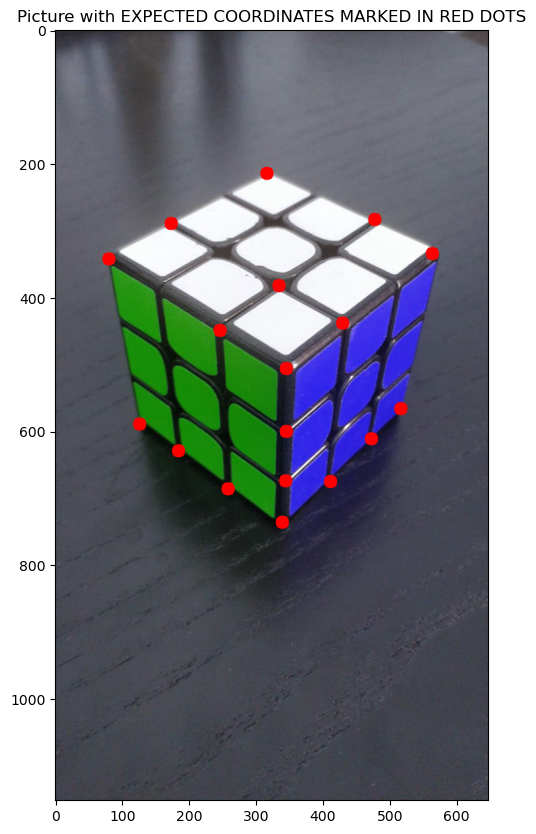

In [15]:
ans_img=img_helper.plot_pixel_points(curr_frame,points_to_be_annotated, (255, 0, 0), circle_rad = 10)
plt.imshow(ans_img)
plt.title("Picture with EXPECTED COORDINATES MARKED IN RED DOTS")

#### Loading the world coordinates

In [16]:
!ls

Assignment-3.ipynb		    helper_utils
bonuses.ipynb			    him_1.json
checker_1.json			    him_2.json
checker_2.json			    q1.ipynb
cheirality_stuff.ipynb		    q2.ipynb
cube_img_pixels.json		    q3.ipynb
cube_world_coordinates.json	    reading_material
data				    saved_data
data_downloaded_from_one_drive.zip  triangulation.ipynb
disambiguation.ipynb		    zhangs_method.ipynb
docs


In [17]:
with open("cube_world_coordinates.json",'r') as fd:
    X_world=json.load(fd)

In [18]:
for curr_elem in X_world:
    curr_elem.append(1)
X_world=np.array(X_world).transpose()

In [19]:
X_world.shape

(4, 18)

# Deriving camera matrices
2. Implement a function that accepts these correspondences and return estimated P matrix.
    Quick recap: $$x_i = P * X_i  where (x_i, X_i)$$ is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].

In [20]:
P_mat, K_mat, R_mat, t_vec, C_vec, error_algebraic, error_geometric, X_proj = dlt_related.apply_DLT_algo(X_world, X_img)

Deriving the A_matrix using the world-image coordinate mappings with 7 points
Shape of A_mat is  (14, 12)
Given A matrix, trying to find best P_vector value where P has 12 dimensions
The P matrix is 
 [[ 0.10411864 -0.08102737 -0.02775729  0.40984698]
 [-0.03233029 -0.03756711 -0.13789985  0.89015419]
 [ 0.00006391  0.00003788 -0.00008809  0.00120851]]
## Now, finding the projected image point using the camera matrix
Shape of A_mat is  (14, 12)
############################
### Algebraic error is  1.2022635307450308e-05

### Mean Geometric error is  4.630122327067484

Ratio between image coordinates is:: 
 [[1.00039291 0.98278633 0.97991406 0.99954387 1.02254626 1.04860653
  1.00104227 0.99134228 0.99487706 1.00248091 1.00082131 0.98655
  0.99900815 1.00244206 0.99636604 0.96670955 1.01632146 0.99581591]
 [1.00077394 0.99876019 1.01100849 1.00077977 0.99714791 1.0089282
  0.99833689 0.99614269 0.99184868 0.99720202 1.0174368  1.00540198
  1.00010886 0.99753409 1.02916848 1.02227346 0.99

In [21]:
dlt_related.verify_consistency(P_mat, K_mat, R_mat, t_vec)

The M_int matrix is 
 [[1077.8219579   -29.39815665  454.12432902    0.        ]
 [   0.         1091.76396159  651.97735891    0.        ]
 [   0.            0.            1.            0.        ]]
The M_ext matrix is 
 [[ 0.58855668 -0.80437345  0.08114424 -1.09671119]
 [-0.58819594 -0.49490323 -0.63960638  0.81257981]
 [ 0.55464094  0.3287159  -0.7644078  10.48731088]
 [ 0.          0.          0.          1.        ]]
The P-reverse engineered is
 [[  903.52713102  -703.14424092  -240.87388967  3556.59527008]
 [ -280.55779549  -326.00219119 -1196.6757786   7724.63460033]
 [    0.55464094     0.3287159     -0.7644078     10.48731088]]

Elementwise-Ratio between P original and P reverse engineered: 
 [[0.00011524 0.00011524 0.00011524 0.00011524]
 [0.00011524 0.00011524 0.00011524 0.00011524]
 [0.00011524 0.00011524 0.00011524 0.00011524]]


# Visualizing results
3. Visualize the world points on the image using P matrix and report reprojection error of your P matrix for the same correspondences. You need to implement three different functions named `get_reprojected_points(P, X_world)`, `visualise(P, X_world, img_path)` and `get_reprojection_err(P, X_world, X_image)`.

`get_reprojected_points(P, X_world)` is present in: `apply_DLT_algo()` in `dlt_related.py`

`get_reprojection_err(P, X_world, X_image)` is present in: `apply_DLT_algo()` in `dlt_related.py`

Text(0.5, 1.0, 'Picture with Predicted COORDINATES MARKED IN YELLOW DOTS and original annotated in RED COLOR')

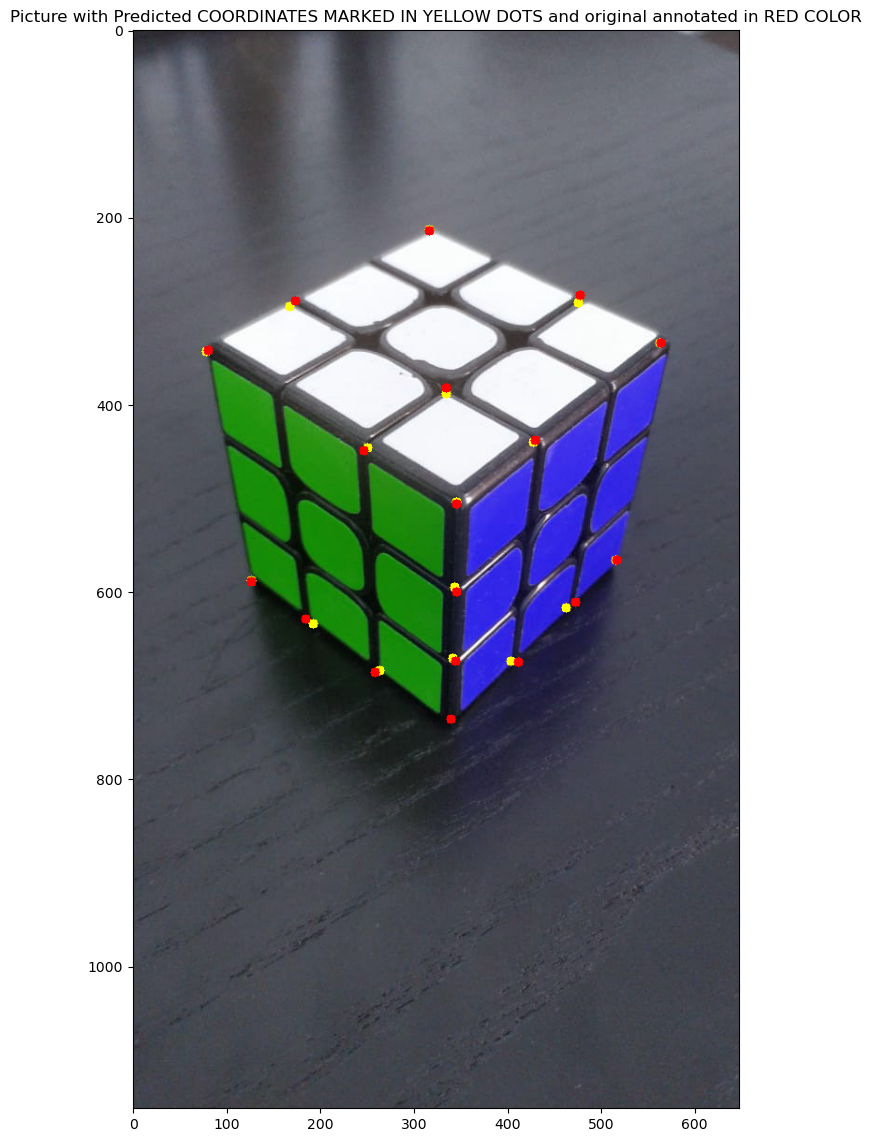

In [22]:
points_to_be_annotated_proj=[[int(X_proj[:,i][0]),int(X_proj[:,i][1])] for i in range(X_proj.shape[1])]
ans_img=img_helper.plot_pixel_points(curr_frame,points_to_be_annotated_proj, (255, 255,0),5)
ans_img=img_helper.plot_pixel_points(ans_img,points_to_be_annotated, (255, 0,0),5)

        
plt.rcParams["figure.figsize"] = (14,14)

plt.imshow(ans_img)
plt.title("Picture with Predicted COORDINATES MARKED IN YELLOW DOTS and original annotated in RED COLOR")

# Breaking the matrix into intrinsic and extrinsic
4. Write the function that returns K, R, t given P as an argument. Next use `np.isclose()` to verify the R,K,T values.

In [23]:
P_mat, P_mat.shape

(array([[ 1.04118642e-01, -8.10273656e-02, -2.77572873e-02,
          4.09846982e-01],
        [-3.23302926e-02, -3.75671124e-02, -1.37899851e-01,
          8.90154189e-01],
        [ 6.39144739e-05,  3.78798282e-05, -8.80871189e-05,
          1.20851331e-03]]),
 (3, 4))

In [24]:
K_mat, K_mat.shape

(array([[ 1.07782196e+03, -2.93981567e+01,  4.54124329e+02],
        [ 0.00000000e+00,  1.09176396e+03,  6.51977359e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 (3, 3))

In [25]:
R_mat, R_mat.shape

(array([[ 0.58855668, -0.80437345,  0.08114424],
        [-0.58819594, -0.49490323, -0.63960638],
        [ 0.55464094,  0.3287159 , -0.7644078 ]]),
 (3, 3))

In [26]:
t_vec, t_vec.shape

(array([-1.09671119,  0.81257981, 10.48731088]), (3,))

In [27]:
rt_stacked = np.vstack((R_mat.T, t_vec)).T

In [28]:
rt_stacked.shape, rt_stacked

((3, 4),
 array([[ 0.58855668, -0.80437345,  0.08114424, -1.09671119],
        [-0.58819594, -0.49490323, -0.63960638,  0.81257981],
        [ 0.55464094,  0.3287159 , -0.7644078 , 10.48731088]]))

In [29]:
reconstructed_camera_mat = K_mat@rt_stacked

In [30]:
reconstructed_camera_mat, reconstructed_camera_mat.shape

(array([[ 9.03527131e+02, -7.03144241e+02, -2.40873890e+02,
          3.55659527e+03],
        [-2.80557795e+02, -3.26002191e+02, -1.19667578e+03,
          7.72463460e+03],
        [ 5.54640941e-01,  3.28715896e-01, -7.64407801e-01,
          1.04873109e+01]]),
 (3, 4))

In [31]:
P_mat/=P_mat[-1,-1]

In [32]:
reconstructed_camera_mat /= reconstructed_camera_mat[-1,-1]

In [33]:
np.isclose(P_mat, reconstructed_camera_mat)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

# About Ransac and Zhang
5. Read upon Ransac based DLT and Zhangs method for camera caliberation and write the steps involved in each.

### Please find my answers to these in the `docs` folder.

#### About RANSAC: Please find details in: `docs/RANSAC and Zhang.pdf`


#### About Zhangs: Please find details in: `docs/RANSAC and Zhang.pdf` and pages 20 to 28 in `docs/DLT and Zhang's Proof.pdf`
